In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Цель:
Понять, от каких факторов зависит ценообразование на автомобили, и построить регрессионные модели для предсказания стоимости машин.

In [2]:
# Считываем данные.

dir_path = '~/data_files/'
df = pd.read_csv(dir_path + 'cars.csv', index_col='car_ID')
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
# Посмотрим на размер датасета.

df.shape

(205, 25)

In [4]:
df.dtypes

symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [5]:
# Приведём названия всех полей к одинаковому стилю.

df = df.rename(columns={'CarName':'car_name'})

In [6]:
# Проверим датасет на наличие пропущенных значений.

df.isna().sum()

symboling           0
car_name            0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [7]:
# Проверим датасет на наличие дубликатов записей.

df.duplicated().sum()

0

In [8]:
# Создадим новый признак – марку автомобиля (название компании производителя).

df['company'] = df.car_name.apply(lambda x: x.split(' ')[0])
df.head()

,symboling,car_name,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,company
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [9]:
# Больше название машин нам не понадобится, поэтому удалим это поле, чтобы не мешало дальнейшему расчёту корреляций.

df = df.drop(columns='car_name')
df.dtypes

symboling             int64
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
company              object
dtype: object

In [10]:
# Посмотрим на число уникальных производителей.

pd.Series(df.company.unique())

0     alfa-romero
1            audi
2             bmw
3       chevrolet
4           dodge
5           honda
6           isuzu
7          jaguar
8           maxda
9           mazda
10          buick
11        mercury
12     mitsubishi
13         Nissan
14         nissan
15        peugeot
16       plymouth
17        porsche
18       porcshce
19        renault
20           saab
21         subaru
22         toyota
23        toyouta
24      vokswagen
25     volkswagen
26             vw
27          volvo
dtype: object

In [11]:
# Названия многих компаний написаны с ошибками, поэтому придётся в ручную это исправить.

df['company'] = df.company.apply(lambda x: x.lower().replace('maxda','mazda') \
                                              .replace('porcshce', 'porsche') \
                                              .replace('toyouta','toyota') \
                                              .replace('vokswagen','volkswagen') \
                                              .replace('vw','volkswagen'))
df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,company
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
2,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
3,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
4,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
5,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [12]:
print('Число истинно-уникальных названий компаний производителей =', df.company.nunique())

Число истинно-уникальных названий компаний производителей = 22


In [13]:
# Посмотрим на примерное распределение цен автомобилей.

df["price"].describe().round(2)

count      205.00
mean     13276.71
std       7988.85
min       5118.00
25%       7788.00
50%      10295.00
75%      16503.00
max      45400.00
Name: price, dtype: float64

Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них, относящуюся к наиболее важным.

In [14]:
list_of_column_names = ['price', 'company', 'fueltype', 'aspiration', 'carbody', 'drivewheel',
                        'wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginetype',
                        'cylindernumber', 'enginesize', 'boreratio', 'horsepower']
df = df[df.columns.intersection(list_of_column_names)].copy()
df.head()


,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,price,company
car_ID,,,,,,,,,,,,,,,
1,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,13495.0,alfa-romero
2,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,16500.0,alfa-romero
3,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,six,152,2.68,154,16500.0,alfa-romero
4,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,four,109,3.19,102,13950.0,audi
5,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,five,136,3.19,115,17450.0,audi


<AxesSubplot:>

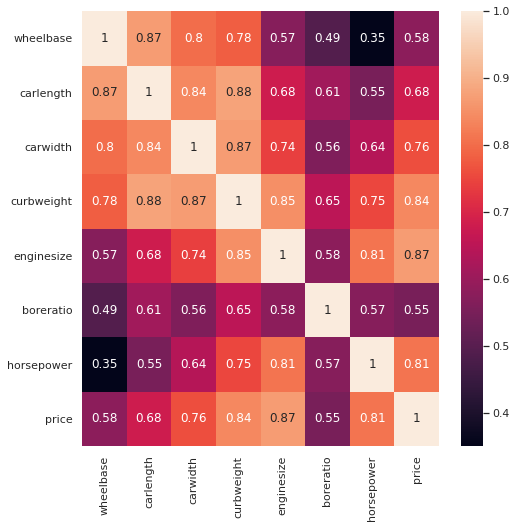

In [15]:
# Приступим к расчёту коэффициентов корреляции.
# Начнём с коэффициентов корреляции Пирсона между всеми числовыми показателями датасета.

pearson_corr = df.corr(method='pearson').round(2)

# Построим heatmap коэффициентов корреляции Пирсона.
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(pearson_corr,
    annot=True,
    xticklabels=pearson_corr.columns,
    yticklabels=pearson_corr.columns)

<AxesSubplot:>

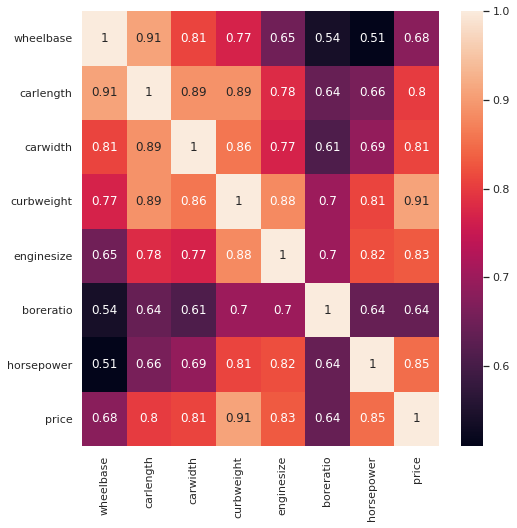

In [16]:
# Теперь рассчитаем коэффициенты корреляции Спирмена между всеми числовыми показателями датасета.

spearman_corr = df.corr(method='spearman').round(2)

# Построим heatmap коэффициентов корреляции Спирмена.
sns.heatmap(spearman_corr,
    annot=True,
    xticklabels=spearman_corr.columns,
    yticklabels=spearman_corr.columns)

<AxesSubplot:>

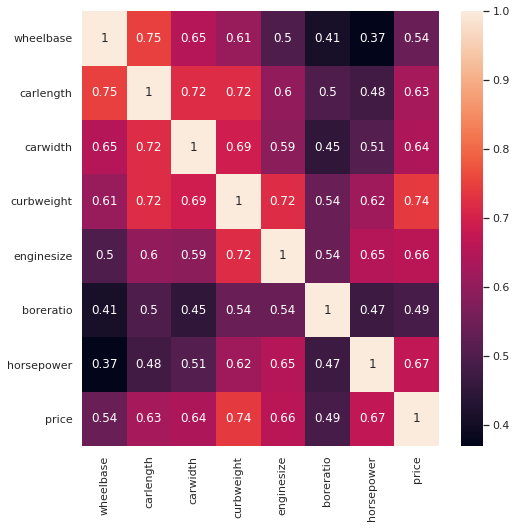

In [17]:
# И напоследок рассчитаем коэффициенты корреляции Кенделла между всеми числовыми показателями датасета.

kendall_corr = df.corr(method='kendall').round(2)

# Построим heatmap коэффициентов корреляции Кенделла.
sns.heatmap(kendall_corr,
    annot=True,
    xticklabels=kendall_corr.columns,
    yticklabels=kendall_corr.columns)

Наиболее важным параметром для отслеживания у нас является цена (price), поскольку именно её мы должны предсказывать. Если смотреть на наиболее коррелирующие с ценой параметры, то:

- для корреляции Пирсона самую сильную связь с ценой имеют: размер двигателя (enginesize), вес машины (curbweight), число лошадиных сил (horsepower);
- для корреляции Спирмена самую сильную связь с ценой имеют: вес машины (curbweight), число лошадиных сил (horsepower), размер двигателя (enginesize), ширина машины (carwidth);
- для корреляции Кенделла самую сильную связь с ценой имеют: вес машины (curbweight), число лошадиных сил (horsepower), размер двигателя (enginesize).

Итого, претендентами на регрессионный анализ становятся следующие параметры: вес машины (curbweight), число лошадиных сил (horsepower), размер двигателя (enginesize).

Что касается категориальных переменных, то линейная регрессия в Python не справляется со строковым типом object в Pandas, поэтому проведём one-hot encoding: создадим фиктивные переменные на основе изначальных категорий, которые будут принимать бинарные значения 0 или 1 в зависимости от того, содержит ли данная запись это значение категории или нет.

In [18]:
string_column_names = list(df.select_dtypes(include=['object']).columns)
string_column_names

['fueltype',
 'aspiration',
 'carbody',
 'drivewheel',
 'enginetype',
 'cylindernumber',
 'company']

In [19]:
df_dummy = pd.get_dummies(data=df[string_column_names], drop_first = True)
df_dummy.head()

,fueltype_gas,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginetype_dohcv,enginetype_l,...,company_nissan,company_peugeot,company_plymouth,company_porsche,company_renault,company_saab,company_subaru,company_toyota,company_volkswagen,company_volvo
car_ID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

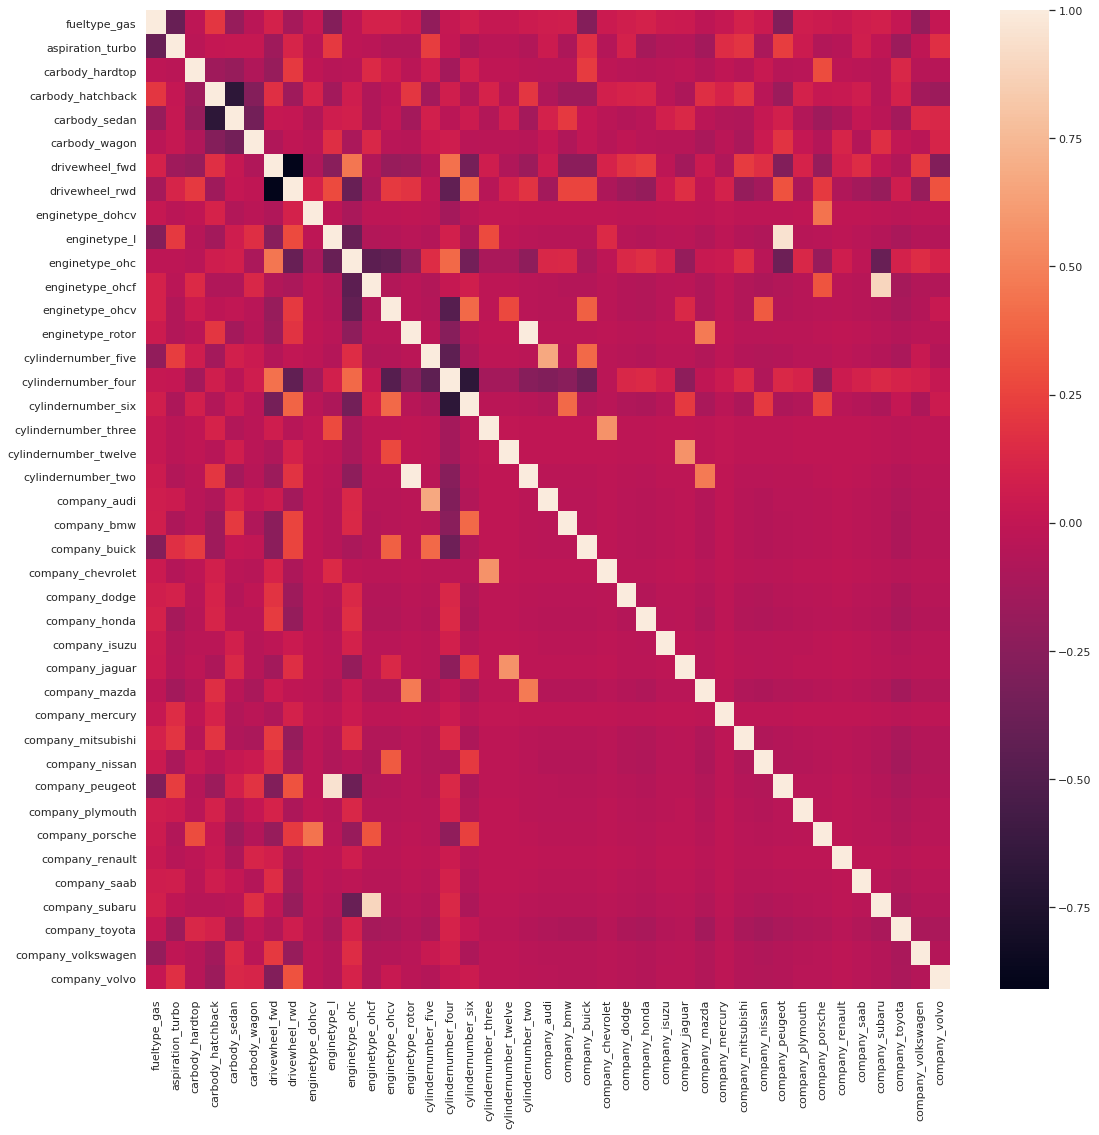

In [20]:
# Рассчитаем коэффициенты корреляции Пирсона между всеми фиктивными показателями датасета.

pearson_corr = df_dummy.corr(method='pearson').round(2)

# Построим heatmap коэффициентов корреляции Пирсона.
sns.set(rc={'figure.figsize':(18,18)})
sns.heatmap(pearson_corr,
    xticklabels=pearson_corr.columns,
    yticklabels=pearson_corr.columns)

Особо полезных выводов по полученным корреляциям сделать нельзя. Поэтому объединим числовые и преобразованные категориальные переменные, после чего построим регресионные модели для полученного датасета.

In [21]:
training_dataset = pd.get_dummies(data=df, drop_first = True)
training_dataset.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,fueltype_gas,aspiration_turbo,...,company_nissan,company_peugeot,company_plymouth,company_porsche,company_renault,company_saab,company_subaru,company_toyota,company_volkswagen,company_volvo
car_ID,,,,,,,,,,,,,,,,,,,,,
1,88.6,168.8,64.1,2548,130,3.47,111,13495.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,88.6,168.8,64.1,2548,130,3.47,111,16500.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,94.5,171.2,65.5,2823,152,2.68,154,16500.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,99.8,176.6,66.2,2337,109,3.19,102,13950.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,99.4,176.6,66.4,2824,136,3.19,115,17450.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Построим модель линейной регрессии всего с одним предиктором цены (price) - числом лошадиных сил (horsepower).
# Расчёт проводится при помощи библиотеки statsmodels.

price_linear_model1 = smf.ols('price ~ horsepower', data=training_dataset).fit()

In [23]:
price_linear_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           1.48e-48
Time:                        16:38:08   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.000   -5555.163   -1888.360
horsepower   163.2631      8.351     19.549      0.000     146.796     179.730
==============================================================================
Omnibus:                       47.741   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.702
Skew:                           1.141   Prob(JB):                     1.22e-20
Kurtosis:                       5.352   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Построим модель линейной регрессии всего с одним предиктором цены (price) - размером двигателя (enginesize).
# Расчёт проводится при помощи библиотеки statsmodels.

price_linear_model2 = smf.ols('price ~ enginesize', data=training_dataset).fit()

In [25]:
price_linear_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     657.6
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           1.35e-65
Time:                        16:38:08   Log-Likelihood:                -1984.4
No. Observations:                 205   AIC:                             3973.
Df Residuals:                     203   BIC:                             3979.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8005.4455    873.221     -9.168      0.000   -9727.191   -6283.700
enginesize   167.6984      6.539     25.645      0.000     154.805     180.592
==============================================================================
Omnibus:                       23.788   Durbin-Watson:                   0.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.092
Skew:                           0.717   Prob(JB):                     6.52e-08
Kurtosis:                       4.348   Cond. No.                         429.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Построим модель линейной регрессии всего с одним предиктором цены (price) - весом машины (curbweight).
# Расчёт проводится при помощи библиотеки statsmodels.

price_linear_model3 = smf.ols('price ~ curbweight', data=training_dataset).fit()

In [27]:
price_linear_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     468.6
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           1.21e-54
Time:                        16:38:08   Log-Likelihood:                -2009.8
No. Observations:                 205   AIC:                             4024.
Df Residuals:                     203   BIC:                             4030.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.948e+04   1543.962    -12.614      0.000   -2.25e+04   -1.64e+04
curbweight    12.8162      0.592     21.647      0.000      11.649      13.984
==============================================================================
Omnibus:                       85.362   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.847
Skew:                           1.591   Prob(JB):                     7.34e-84
Kurtosis:                       8.890   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Построим модель линейной регрессии со всеми предикторами, кроме марок машин (company), для прогнозирования цены (price).
# Расчёт проводится при помощи библиотеки statsmodels.

Y = df.price
temp_df = df.drop(columns=['price', 'company'])
X = pd.get_dummies(data=temp_df, drop_first = True)

price_linear_model4 = sm.OLS(Y, sm.add_constant(X)).fit()

In [29]:
price_linear_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           9.86e-81
Time:                        16:38:08   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+04    1.3e+04     -1.309      0.192   -4.26e+04    8625.219
wheelbase                71.1868     87.028      0.818      0.414    -100.552     242.925
carlength               -51.3497     50.341     -1.020      0.309    -150.692      47.993
carwidth                541.8700    253.327      2.139      0.034      41.958    1041.782
curbweight                2.9577      1.796      1.647      0.101      -0.585       6.501
enginesize               36.0515     22.376      1.611      0.109      -8.105      80.208
boreratio             -2230.4519   1731.681     -1.288      0.199   -5647.719    1186.815
horsepower               86.8164     16.717      5.193      0.000      53.827     119.806
fueltype_gas          -2423.0935    975.579     -2.484      0.014   -4348.283    -497.904
aspiration_turbo      -1139.2334    787.230     -1.447      0.150   -2692.738     414.271
carbody_hardtop       -3728.0949   1519.366     -2.454      0.015   -6726.383    -729.807
carbody_hatchback     -4639.1279   1294.594     -3.583      0.000   -7193.855   -2084.401
carbody_sedan         -3337.7854   1356.075     -2.461      0.015   -6013.838    -661.732
carbody_wagon         -4315.4661   1465.089     -2.946      0.004   -7206.646   -1424.287
drivewheel_fwd          297.2402   1121.766      0.265      0.791   -1916.431    2510.912
drivewheel_rwd         1939.1594   1226.536      1.581      0.116    -481.263    4359.582
enginetype_dohcv      -1.713e+04   4540.120     -3.773      0.000   -2.61e+04   -8171.142
enginetype_l           2176.0521   1332.818      1.633      0.104    -454.106    4806.211
enginetype_ohc         4006.5687    897.437      4.464      0.000    2235.584    5777.553
enginetype_ohcf        5421.2822   1388.078      3.906      0.000    2682.076    8160.488
enginetype_ohcv       -5001.2242   1345.435     -3.717      0.000   -7656.280   -2346.169
enginetype_rotor      -5196.6413   2084.532     -2.493      0.014   -9310.217   -1083.066
cylindernumber_five   -1.389e+04   2891.599     -4.802      0.000   -1.96e+04   -8180.353
cylindernumber_four   -1.618e+04   3243.610     -4.989      0.000   -2.26e+04   -9780.800
cylindernumber_six    -1.175e+04   2287.516     -5.135      0.000   -1.63e+04   -7231.547
cylindernumber_three  -9264.0553   4750.899     -1.950      0.053   -1.86e+04     111.279
cylindernumber_twelve -1.214e+04   3386.507     -3.585      0.000   -1.88e+04   -5458.378
cylindernumber_two    -5196.6413   2084.532     -2.493      0.014   -9310.217   -1083.066
==============================================================================
Omnibus:                       18.493   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.728
Skew:                           0.293   Prob(JB):       

In [30]:
# Построим модель линейной регрессии со всеми предикторами для прогнозирования цены (price).
# Расчёт проводится при помощи библиотеки statsmodels.

Y = df.price
temp_df = df.drop(columns=['price'])
X = pd.get_dummies(data=temp_df, drop_first = True)

price_linear_model5 = sm.OLS(Y, sm.add_constant(X)).fit()

In [31]:
price_linear_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           4.86e-89
Time:                        16:38:08   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.472e+04   1.17e+04     -2.959      0.004   -5.79e+04   -1.15e+04
wheelbase               147.1396     76.234      1.930      0.055      -3.429     297.708
carlength              -113.2012     48.949     -2.313      0.022    -209.881     -16.522
carwidth                809.1860    214.508      3.772      0.000     385.514    1232.858
curbweight                4.1822      1.582      2.643      0.009       1.057       7.307
enginesize               61.4212     23.643      2.598      0.010      14.724     108.119
boreratio             -4319.4728   1759.825     -2.454      0.015   -7795.288    -843.657
horsepower               34.7010     18.000      1.928      0.056      -0.850      70.252
fueltype_gas           -243.7792    908.310     -0.268      0.789   -2037.774    1550.216
aspiration_turbo        596.6566    676.548      0.882      0.379    -739.588    1932.902
carbody_hardtop       -2556.7157   1213.929     -2.106      0.037   -4954.337    -159.094
carbody_hatchback     -3044.4196   1107.064     -2.750      0.007   -5230.972    -857.867
carbody_sedan         -2256.9173   1154.971     -1.954      0.052   -4538.090      24.256
carbody_wagon         -2815.4970   1223.156     -2.302      0.023   -5231.343    -399.651
drivewheel_fwd         -169.4926    888.585     -0.191      0.849   -1924.531    1585.545
drivewheel_rwd          231.9066   1039.685      0.223      0.824   -1821.566    2285.380
enginetype_dohcv      -8358.0756   4326.239     -1.932      0.055   -1.69e+04     186.645
enginetype_l          -1067.3120   1602.125     -0.666      0.506   -4231.657    2097.033
enginetype_ohc         -273.7175   1063.557     -0.257      0.797   -2374.341    1826.906
enginetype_ohcf        1.031e+04   2672.508      3.857      0.000    5028.873    1.56e+04
enginetype_ohcv       -2393.8587   1214.631     -1.971      0.050   -4792.867       5.150
enginetype_rotor         37.4715   2092.597      0.018      0.986   -4095.600    4170.543
cylindernumber_five   -5235.5232   2887.214     -1.813      0.072   -1.09e+04     466.990
cylindernumber_four   -3741.3604   3542.130     -1.056      0.292   -1.07e+04    3254.673
cylindernumber_six    -5441.5317   2628.646     -2.070      0.040   -1.06e+04    -249.713
cylindernumber_three   1604.1476   2774.698      0.578      0.564   -3876.137    7084.432
cylindernumber_twelve -8097.1585   3616.336     -2.239      0.027   -1.52e+04    -954.561
cylindernumber_two       37.4715   2092.597      0.018      0.986   -4095.600    4170.543
company_audi            437.1040   2125.971      0.206      0.837   -3761.885    4636.093
company_bmw            7993.4998   2105.132      3.797      0.000    3835.671    1.22e+04
company_buick          3431.0969   2472.252      1.388      0.167   -1451.829    8314.023
company_chevrolet     -

Если судить чисто по диагностическим показателям (вроде R^2), то среди всех 5 моделей линейной регрессии, построенных при помощи библиотеки statsmodels, модель со всеми предикторами (price_linear_model5) лучшая.
Большинство коэффициентов, связанных с марками машин (компаниями производителями), статистически незначимы (p-value > 0.05).

Теперь мы будем рассматривать только регрессионные модели из библиотеки scikit-learn, причём не только линейную регрессию, но и другие виды регрессий. Для всех моделей в качестве датасета сразу будет браться таблица со всеми числовыми параметрами (но не категориальными, поскольку они всё равно не дают значительного влияния на цену) и на их основе будет предсказываться цена. Однако сперва надо нормализовать данные, чтобы параметры с большими числовыми значениями не имели преимущества перед параметры с малыми числовыми значениями. Также важно разделить датасет на обучающий и тестовый в пропорции 4:1, чтобы можно было проверить точность обученной модели.

In [32]:
# Разделим датасет на категориальные и числовые параметры.

object_data = df.select_dtypes(include='object')
num_data = df.select_dtypes(exclude='object')

enc = LabelEncoder()
for i in range(0, object_data.shape[1]):
    object_data.iloc[:,i] = enc.fit_transform(object_data.iloc[:,i])   

In [33]:
# Опишем функцию, которая будет тренировать любую регрессионную модель и тестировать её.

def train_and_test_regression_model(model, X_train, Y_train, X_test, Y_test, iteration):
    # тренируем модель
    model.fit(X_train, Y_train)
    # пробуем предсказать целевую метрику
    predictions = model.predict(X_test)
    r2_score_calc = round(r2_score(Y_test, predictions)*100, 2)
    print(f'\tR2-score для {iteration}-й части тестовых данных = ',
          r2_score_calc, '%', sep='')
    print(f'\tСредняя абсолютная ошибка для {iteration}-й части тестовых данных = ',
          round(mean_absolute_error(Y_test, predictions)))
    return r2_score_calc

In [34]:
# Опишем функцию, которая будет подготавливать любую регрессионную модель путём нормализации параметров
# и разделения модели на пропорции для кросс-валидации.

def prepare_regression_model(models, df, n_folds):
    r2_score_matrix = {'LinearRegression' : [],
        'DecisionTreeRegression' : [],
        'RandomForestRegression' : [],
        'KNNRegression' : []
    }
    i = 1
    for train_index, test_index in n_folds.split(df):
        X_train = df.iloc[train_index].drop(columns=['price'])
        X_train = StandardScaler().fit_transform(X_train)
        X_test = df.iloc[test_index].drop(columns=['price'])
        X_test = StandardScaler().fit_transform(X_test)
        Y_train = df.iloc[train_index]['price']
        Y_test = df.iloc[test_index]['price']
        print('============[итерация №', i, ']============', sep='')
        for model_name, model in models.items():
            print('Model name =', model_name)
            r2_score_matrix[model_name].append(train_and_test_regression_model(model, X_train, Y_train, X_test, Y_test, iteration=i))
        i += 1
    return r2_score_matrix

In [35]:
# Зададим постоянное значение random_state.

RND = 42

In [36]:
# Делим датасет на обучающий и тестовый в пропорции 4:1.

kf5 = KFold(n_splits=5, shuffle=True, random_state=RND)

In [37]:
# Построим словарь моделей регрессии.

models = {'LinearRegression' : LinearRegression(),
    'DecisionTreeRegression' : DecisionTreeRegressor(random_state=RND),
    'RandomForestRegression' : RandomForestRegressor(random_state=RND),
    'KNNRegression' : KNeighborsRegressor()
}

In [38]:
# Построим модель линейной регрессии только с числовыми предикторами для прогнозирования цены (price).
# Расчёт проводится при помощи библиотеки scikit-learn.

r2_score_matrix_for_num = prepare_regression_model(models, num_data, kf5)

============[итерация №1]============
Model name = LinearRegression
	R2-score для 1-й части тестовых данных = 81.61%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2689
Model name = DecisionTreeRegression
	R2-score для 1-й части тестовых данных = 91.61%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2014
Model name = RandomForestRegression
	R2-score для 1-й части тестовых данных = 90.16%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  1941
Model name = KNNRegression
	R2-score для 1-й части тестовых данных = 60.65%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2842
============[итерация №2]============
Model name = LinearRegression
	R2-score для 2-й части тестовых данных = 47.15%
	Средняя абсолютная ошибка для 2-й части тестовых данных =  2931
Model name = DecisionTreeRegression
	R2-score для 2-й части тестовых данных = -24.3%
	Средняя абсолютная ошибка для 2-й части тестовых данных =  3983
Model name = RandomForestRegression
	R2-score

In [39]:
# Построим словарь сосредними значениями коэффициента R^2 для каждой из моделей,
# обученных только на числовых предикторах.

r2_mean_score_list = {k : round(np.mean(v), 2) for k, v in r2_score_matrix_for_num.items()}
r2_mean_score_list

{'LinearRegression': 75.37,
 'DecisionTreeRegression': 61.3,
 'RandomForestRegression': 71.78,
 'KNNRegression': 74.18}

In [40]:
# Объединим категориальные и числовые параметры.

full_dataset = pd.concat([num_data, object_data], axis = 1)

In [41]:
# Построим модель линейной регрессии со всеми предикторами для прогнозирования цены (price).
# Расчёт проводится при помощи библиотеки scikit-learn.

r2_score_matrix = prepare_regression_model(models, full_dataset, kf5)

============[итерация №1]============
Model name = LinearRegression
	R2-score для 1-й части тестовых данных = 84.29%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2460
Model name = DecisionTreeRegression
	R2-score для 1-й части тестовых данных = 88.72%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2318
Model name = RandomForestRegression
	R2-score для 1-й части тестовых данных = 92.0%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  1800
Model name = KNNRegression
	R2-score для 1-й части тестовых данных = 79.6%
	Средняя абсолютная ошибка для 1-й части тестовых данных =  2421
============[итерация №2]============
Model name = LinearRegression
	R2-score для 2-й части тестовых данных = 58.15%
	Средняя абсолютная ошибка для 2-й части тестовых данных =  2795
Model name = DecisionTreeRegression
	R2-score для 2-й части тестовых данных = -36.7%
	Средняя абсолютная ошибка для 2-й части тестовых данных =  4006
Model name = RandomForestRegression
	R2-score д

In [42]:
# Построим словарь сосредними значениями коэффициента R^2 для каждой из моделей,
# обученных как на числовых, так и на категориальных предикторах.

r2_mean_score_list = {k : round(np.mean(v), 2) for k, v in r2_score_matrix.items()}
r2_mean_score_list

{'LinearRegression': 75.93,
 'DecisionTreeRegression': 61.47,
 'RandomForestRegression': 73.6,
 'KNNRegression': 76.55}

Как видно из проведенных сравнений с учётом кросс-валидации, наиболее хорошими в плане предсказания цены, при сравнении коэффициента R^2 в качестве метрики ошибки, стали модели линейной регрессии и KNN-регрессии (R^2 ~ 75%). Причём можно смело отбросить все категориальные переменные, поскольку они не повлияли на результат в лучшую сторону. Что касается средней абсолютной ошибки, то в целом для разных моделей регрессии её значения составили от 1500 до 4000 денежных единиц, с учётом того, что изначально заданное распределение цены варьируется от 5000 до 45000 со среднеквадратичным отклонением = 8000.